# How to Train Your ResNet - 8: Bag of Tricks

In the [final post of the series](https://myrtle.ai/how-to-train-your-resnet-8-bag-of-tricks/) we come full circle, speeding up our single-GPU training implementation to take on a field of multi-GPU competitors. Whilst we've been otherwise occupied - investigating [hyperparameter tuning](https://myrtle.ai/learn/how-to-train-your-resnet-5-hyperparameters/), [weight decay](https://myrtle.ai/learn/how-to-train-your-resnet-6-weight-decay/) and [batch norm](https://myrtle.ai/learn/how-to-train-your-resnet-7-batch-norm/) - our entry for training CIFAR10 to 94% test accuracy has slipped five (!) places on the DAWNBench leaderboard:

![](https://drive.google.com/uc?id=1MzB0-FR_oIPVe9PCffvRI9DB13m2YI21)

The top six entries all use 9-layer ResNets which are cousins - or twins - of the network we developed  [earlier in the series](https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/). First place is a 4-GPU implementation from Kakao Brain which completes in an impressive 37s. The single-GPU version of the same comes in third with 68s, an apparent 7s improvement over our single-GPU entry from last year, although close inspection shows that these submissions are using test-time augmentation (TTA). We shall discuss the validity of this approach towards the end of the post (our conclusion is that any reasonable restriction should be based on total inference cost and that the form of mild TTA used here, along with a lightweight network, passes on that front.) Note that our earlier submission, allowing the same TTA, would achieve a time of 60s on a 19 epoch training schedule without further changes.

By the end of the post our single-GPU implementation surpasses the top multi-GPU times comfortably, reclaiming the coveted DAWNBench crown with a time of 34s and achieving a 10× improvement over the single-GPU state-of-the-art at the start of the series! Using the same TTA employed by the Kakao Brain submission, this drops to 26s. We achieve these times by accumulating a series of small (typically 0.1-0.3% in absolute test accuracy) improvements, which can be traded for shorter training times. These improvements are based on a collection of standard and not-so-standard tricks. 

Our main weapon is statistical significance. The standard deviation in test accuracy for a single training run is roughly 0.15% and when comparing between two runs we need to multiply this by $\sqrt{2}$. This is larger than many of the effects that we are measuring. Given that training times soon drop below a minute, we can afford to run experiments 10s-100s of times to make sure that improvements are real and this allows us to make consistent progress.

Sharp experimental results are essential to advancing the field but if a baseline is poorly-tuned or the number of runs too few, experimental validation holds little value. The main goal of today's post is to provide a well-tuned baseline on which to test novel techniques, allowing one to complete a statistically significant number of training runs within minutes on a single GPU. We confirm, at the end of the post, that improvements in training speed translate into improvements in final accuarcy if training is allowed to proceed towards convergence.



### Setup

In [1]:
#@title Lib (RUN ME) - double-click to show/hide code
####################
## CORE
#####################

import inspect
from collections import namedtuple, defaultdict
from functools import partial
import functools
from itertools import chain, count, islice as take

#####################
## dict utils
#####################

union = lambda *dicts: {k: v for d in dicts for (k, v) in d.items()}

make_tuple = lambda path: (path,) if isinstance(path, str) else path

def path_iter(nested_dict, pfx=()):
    for name, val in nested_dict.items():
        if isinstance(val, dict): yield from path_iter(val, pfx+make_tuple(name))
        else: yield (pfx+make_tuple(name), val)  
            
map_values = lambda func, dct: {k: func(v) for k,v in dct.items()}

def map_nested(func, nested_dict):
    return {k: map_nested(func, v) if isinstance(v, dict) else func(v) for k,v in nested_dict.items()}

def group_by_key(seq):
    res = defaultdict(list)
    for k, v in seq: 
        res[k].append(v) 
    return res

reorder = lambda dct, keys: {k: dct[k] for k in keys}

#####################
## graph building
#####################

def identity(value): return value

def build_graph(net, path_map='_'.join):
    net = {path: node if len(node) is 3 else (*node, None) for path, node in path_iter(net)}
    default_inputs = chain([('input',)], net.keys())
    resolve_path = lambda path, pfx: pfx+path if (pfx+path in net or not pfx) else resolve_path(net, path, pfx[:-1])
    return {path_map(path): (typ, value, ([path_map(default)] if inputs is None else [path_map(resolve_path(make_tuple(k), path[:-1])) for k in inputs])) 
            for (path, (typ, value, inputs)), default in zip(net.items(), default_inputs)}

#####################
## network visualisation (requires pydot)
#####################
import IPython.display

class ColorMap(dict):
    palette = (
        'bebada,ffffb3,fb8072,8dd3c7,80b1d3,fdb462,b3de69,fccde5,bc80bd,ccebc5,ffed6f,1f78b4,33a02c,e31a1c,ff7f00,'
        '4dddf8,e66493,b07b87,4e90e3,dea05e,d0c281,f0e189,e9e8b1,e0eb71,bbd2a4,6ed641,57eb9c,3ca4d4,92d5e7,b15928'
    ).split(',')
 
    def __missing__(self, key):
        self[key] = self.palette[len(self) % len(self.palette)]
        return self[key]

def make_pydot(nodes, edges, direction='LR', sep='_', **kwargs):
    from pydot import Dot, Cluster, Node, Edge
    class Subgraphs(dict):
        def __missing__(self, path):
            *parent, label = path
            subgraph = Cluster(sep.join(path), label=label, style='rounded, filled', fillcolor='#77777744')
            self[tuple(parent)].add_subgraph(subgraph)
            return subgraph
    g = Dot(rankdir=direction, directed=True, **kwargs)
    g.set_node_defaults(
        shape='box', style='rounded, filled', fillcolor='#ffffff')
    subgraphs = Subgraphs({(): g})
    for path, attr in nodes:
        *parent, label = path.split(sep)
        subgraphs[tuple(parent)].add_node(
            Node(name=path, label=label, **attr))
    for src, dst, attr in edges:
        g.add_edge(Edge(src, dst, **attr))
    return g

class DotGraph():
    colors = ColorMap()   
    def __init__(self, graph, size=15, direction='LR'):
        self.nodes = [(k, {
            'tooltip': '%s %.1000r' % (typ, value), 
            'fillcolor': '#'+self.colors[typ],
        }) for k, (typ, value, inputs) in graph.items()] 
        self.edges = [(src, k, {}) for (k, (_,_,inputs)) in graph.items() for src in inputs]
        self.size, self.direction = size, direction

    def dot_graph(self, **kwargs):
        return make_pydot(self.nodes, self.edges, size=self.size, 
                            direction=self.direction, **kwargs)

    def svg(self, **kwargs):
        return self.dot_graph(**kwargs).create(format='svg').decode('utf-8')

    try:
        import pydot
        def _repr_svg_(self):
            return self.svg()
    except ImportError:
        def __repr__(self):
            return 'pydot is needed for network visualisation'


#####################
## Layers
##################### 

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from collections import namedtuple
import copy

torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')
    
class Network(nn.Module):
    def __init__(self, net, loss=None):
        super().__init__()
        self.graph = {path: (typ, typ(**params), inputs) for path, (typ, params, inputs) in build_graph(net).items()}
        self.loss = loss or identity
        for path, (_,node,_) in self.graph.items(): 
            setattr(self, path, node)
    
    def nodes(self):
        return (node for _,node,_ in self.graph.values())
    
    def forward(self, inputs):
        outputs = dict(inputs)
        for k, (_, node, ins) in self.graph.items():
            outputs[k] = node(*[outputs[x] for x in ins])
        return outputs
    
    def half(self):
        for node in self.nodes():
            if isinstance(node, nn.Module) and not isinstance(node, nn.BatchNorm2d):
                node.half()
        return self

build_model = lambda network, loss: Network(network, loss).half().to(device)
show = lambda network, size=15: display(DotGraph(network.graph if isinstance(network, Network) else build_graph(network), size=size))
    
class Add(namedtuple('Add', [])):
    def __call__(self, x, y): return x + y 
    
class AddWeighted(namedtuple('AddWeighted', ['wx', 'wy'])):
    def __call__(self, x, y): return self.wx*x + self.wy*y 
    
class Identity(namedtuple('Identity', [])):
    def __call__(self, x): return x

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False): #lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super().train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)
        
class Mul(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight
    def __call__(self, x): 
        return x*self.weight
    
class Flatten(nn.Module):
    def forward(self, x): 
        return x.view(x.size(0), x.size(1))

# Losses
class CrossEntropyLoss(namedtuple('CrossEntropyLoss', [])):
    def __call__(self, log_probs, target):
        return torch.nn.functional.nll_loss(log_probs, target, reduction='none')
    
class KLLoss(namedtuple('KLLoss', [])):        
    def __call__(self, log_probs):
        return -log_probs.mean(dim=1)

class Correct(namedtuple('Correct', [])):
    def __call__(self, classifier, target):
        return classifier.max(dim = 1)[1] == target

class LogSoftmax(namedtuple('LogSoftmax', ['dim'])):
    def __call__(self, x):
        return torch.nn.functional.log_softmax(x, self.dim, _stacklevel=5)

    
# node definitions   
from inspect import signature    
empty_signature = inspect.Signature()

class node_def(namedtuple('node_def', ['type'])):
    def __call__(self, *args, **kwargs):
        return (self.type, dict(signature(self.type).bind(*args, **kwargs).arguments))

conv = node_def(nn.Conv2d)
linear = node_def(nn.Linear)
batch_norm = node_def(BatchNorm)
pool = node_def(nn.MaxPool2d)
relu = node_def(nn.ReLU)
    
def map_types(mapping, net):
    def f(node):
        typ, *rest = node
        return (mapping.get(typ, typ), *rest)
    return map_nested(f, net) 

#####################
## Compat
##################### 

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()  
    return x
  
def flip_lr(x):
    if isinstance(x, torch.Tensor):
        return torch.flip(x, [-1]) 
    return x[..., ::-1].copy()
  
trainable_params = lambda model: {k:p for k,p in model.named_parameters() if p.requires_grad}

#####################
## Optimisers
##################### 

from functools import partial

def nesterov_update(w, dw, v, lr, weight_decay, momentum):
    dw.add_(weight_decay, w).mul_(-lr)
    v.mul_(momentum).add_(dw)
    w.add_(dw.add_(momentum, v))

norm = lambda x: torch.norm(x.reshape(x.size(0),-1).float(), dim=1)[:,None,None,None]

def LARS_update(w, dw, v, lr, weight_decay, momentum):
    nesterov_update(w, dw, v, lr*(norm(w)/(norm(dw)+1e-2)).to(w.dtype), weight_decay, momentum)

def zeros_like(weights):
    return [torch.zeros_like(w) for w in weights]

def optimiser(weights, param_schedule, update, state_init):
    weights = list(weights)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': 0, 'weights': weights,  'opt_state': state_init(weights)}

def opt_step(update, param_schedule, step_number, weights, opt_state):
    step_number += 1
    param_values = {k: f(step_number) for k, f in param_schedule.items()}
    for w, v in zip(weights, opt_state):
        if w.requires_grad:
            update(w.data, w.grad.data, v, **param_values)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': step_number, 'weights': weights,  'opt_state': opt_state}

LARS = partial(optimiser, update=LARS_update, state_init=zeros_like)
SGD = partial(optimiser, update=nesterov_update, state_init=zeros_like)
  
class PiecewiseLinear(namedtuple('PiecewiseLinear', ('knots', 'vals'))):
    def __call__(self, t):
        return np.interp([t], self.knots, self.vals)[0]
     
class Const(namedtuple('Const', ['val'])):
    def __call__(self, x):
        return self.val

#####################
## DATA
##################### 

import torchvision
from functools import lru_cache as cache

@cache(None)
def cifar10(root='./data'):
    download = lambda train: torchvision.datasets.CIFAR10(root=root, train=train, download=True)
    return {k: {'data': torch.tensor(v.data), 'targets': torch.tensor(v.targets)} 
            for k,v in [('train', download(True)), ('valid', download(False))]}
  
cifar10_mean, cifar10_std = [
    (125.31, 122.95, 113.87), # equals np.mean(cifar10()['train']['data'], axis=(0,1,2)) 
    (62.99, 62.09, 66.70), # equals np.std(cifar10()['train']['data'], axis=(0,1,2))
]
cifar10_classes= 'airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck'.split(', ')

#####################
## data preprocessing
#####################
mean, std = [torch.tensor(x, device=device, dtype=torch.float16) for x in (cifar10_mean, cifar10_std)]

normalise = lambda data, mean=mean, std=std: (data - mean)/std
unnormalise = lambda data, mean=mean, std=std: data*std + mean
pad = lambda data, border: nn.ReflectionPad2d(border)(data)
transpose = lambda x, source='NHWC', target='NCHW': x.permute([source.index(d) for d in target]) 
to = lambda *args, **kwargs: (lambda x: x.to(*args, **kwargs))

def preprocess(dataset, transforms):
    dataset = copy.copy(dataset)
    for transform in reversed(transforms):
        dataset['data'] = transform(dataset['data'])
    return dataset

#####################
## Data augmentation
#####################

chunks = lambda data, splits: (data[start:end] for (start, end) in zip(splits, splits[1:]))

even_splits = lambda N, num_chunks: np.cumsum([0] + [(N//num_chunks)+1]*(N % num_chunks)  + [N//num_chunks]*(num_chunks - (N % num_chunks)))

def shuffled(xs, inplace=False):
    xs = xs if inplace else copy.copy(xs) 
    np.random.shuffle(xs)
    return xs

def transformed(data, targets, transform, max_options=None, unshuffle=False):
    i = torch.randperm(len(data), device=device)
    data = data[i]
    options = shuffled(transform.options(data.shape), inplace=True)[:max_options]
    data = torch.cat([transform.apply(x, **choice) for choice, x in zip(options, chunks(data, even_splits(len(data), len(options))))])
    return (data[torch.argsort(i)], targets) if unshuffle else (data, targets[i])

class Batches():
    def __init__(self, batch_size, transforms=(), dataset=None, shuffle=True, drop_last=False, max_options=None):
        self.dataset, self.transforms, self.shuffle, self.max_options = dataset, transforms, shuffle, max_options
        N = len(dataset['data'])
        self.splits = list(range(0, N+1, batch_size))
        if not drop_last and self.splits[-1] != N:
            self.splits.append(N)
     
    def __iter__(self):
        data, targets = self.dataset['data'], self.dataset['targets']
        for transform in self.transforms:
            data, targets = transformed(data, targets, transform, max_options=self.max_options, unshuffle=not self.shuffle)
        if self.shuffle:
            i = torch.randperm(len(data), device=device)
            data, targets = data[i], targets[i]
        return ({'input': x.clone(), 'target': y} for (x, y) in zip(chunks(data, self.splits), chunks(targets, self.splits)))
    
    def __len__(self): 
        return len(self.splits) - 1
    
#####################
## Augmentations
#####################

class Crop(namedtuple('Crop', ('h', 'w'))):
    def apply(self, x, x0, y0):
        return x[..., y0:y0+self.h, x0:x0+self.w] 

    def options(self, shape):
        *_, H, W = shape
        return [{'x0': x0, 'y0': y0} for x0 in range(W+1-self.w) for y0 in range(H+1-self.h)]
    
class FlipLR(namedtuple('FlipLR', ())):
    def apply(self, x, choice):
        return flip_lr(x) if choice else x 
        
    def options(self, shape):
        return [{'choice': b} for b in [True, False]]

class Cutout(namedtuple('Cutout', ('h', 'w'))):
    def apply(self, x, x0, y0):
        x[..., y0:y0+self.h, x0:x0+self.w] = 0.0
        return x

    def options(self, shape):
        *_, H, W = shape
        return [{'x0': x0, 'y0': y0} for x0 in range(W+1-self.w) for y0 in range(H+1-self.h)]  

#####################
## TRAINING
#####################

import time

class Timer():
    def __init__(self, synch=None):
        self.synch = synch or (lambda: None)
        self.synch()
        self.times = [time.perf_counter()]
        self.total_time = 0.0

    def __call__(self, update_total=True):
        self.synch()
        self.times.append(time.perf_counter())
        delta_t = self.times[-1] - self.times[-2]
        if update_total:
            self.total_time += delta_t
        return delta_t

default_table_formats = {float: '{:{w}.4f}', str: '{:>{w}s}', 'default': '{:{w}}', 'title': '{:>{w}s}'}

def table_formatter(val, is_title=False, col_width=12, formats=None):
    formats = formats or default_table_formats
    type_ = lambda val: float if isinstance(val, (float, np.float)) else type(val)
    return (formats['title'] if is_title else formats.get(type_(val), formats['default'])).format(val, w=col_width)

every = lambda n, col: (lambda data: data[col] % n == 0)

class Table():
    def __init__(self, keys=None, report=(lambda data: True), formatter=table_formatter):
        self.keys, self.report, self.formatter = keys, report, formatter
        self.log = []
        
    def append(self, data):
        self.log.append(data)
        data = {' '.join(p): v for p,v in path_iter(data)}
        self.keys = self.keys or data.keys()
        if len(self.log) is 1:
            print(*(self.formatter(k, True) for k in self.keys))
        if self.report(data):
            print(*(self.formatter(data[k]) for k in self.keys))
            
    def df(self):
        return pd.DataFrame([{'_'.join(p): v for p,v in path_iter(row)} for row in self.log])     
            
def reduce(batches, state, steps):
    #state: is a dictionary
    #steps: are functions that take (batch, state)
    #and return a dictionary of updates to the state (or None)
    
    for batch in chain(batches, [None]): 
    #we send an extra batch=None at the end for steps that 
    #need to do some tidying-up (e.g. log_activations)
        for step in steps:
            updates = step(batch, state)
            if updates:
                for k,v in updates.items():
                    state[k] = v                  
    return state
  
#define keys in the state dict as constants
MODEL = 'model'
VALID_MODEL = 'valid_model'
OUTPUT = 'output'
OPTS = 'optimisers'
ACT_LOG = 'activation_log'
WEIGHT_LOG = 'weight_log'

#step definitions
def forward(training_mode):
    def step(batch, state):
        if not batch: return
        model = state[MODEL] if training_mode or (VALID_MODEL not in state) else state[VALID_MODEL]
        if model.training != training_mode: #without the guard it's slow!
            model.train(training_mode)
        return {OUTPUT: model.loss(model(batch))}
    return step

def forward_tta(tta_transforms):
    def step(batch, state):
        if not batch: return
        model = state[MODEL] if (VALID_MODEL not in state) else state[VALID_MODEL]
        if model.training:
            model.train(False)
        logits = torch.mean(torch.stack([model({'input': transform(batch['input'].clone())})['logits'].detach() for transform in tta_transforms], dim=0), dim=0)
        return {OUTPUT: model.loss(dict(batch, logits=logits))}
    return step

def backward(dtype=torch.float16):
    def step(batch, state):
        state[MODEL].zero_grad()
        if not batch: return
        state[OUTPUT]['loss'].to(dtype).sum().backward()
    return step

def opt_steps(batch, state):
    if not batch: return
    return {OPTS: [opt_step(**opt) for opt in state[OPTS]]}

def log_activations(node_names=('loss', 'acc')):
    logs = []
    def step(batch, state):
        if batch:
            logs.extend((k, state[OUTPUT][k].detach()) for k in node_names)
        else:
            res = map_values((lambda xs: to_numpy(torch.cat(xs)).astype(np.float)), group_by_key(logs))
            logs.clear()
            return {ACT_LOG: res}
    return step

def update_ema(momentum, update_freq=1):
    n = iter(count())
    rho = momentum**update_freq
    def step(batch, state):
        if not batch: return
        if (next(n) % update_freq) != 0: return
        for v, ema_v in zip(state[MODEL].state_dict().values(), state[VALID_MODEL].state_dict().values()):
            ema_v *= rho
            ema_v += (1-rho)*v
    return step

train_steps = (forward(training_mode=True), log_activations(('loss', 'acc')), backward(), opt_steps)
valid_steps = (forward(training_mode=False), log_activations(('loss', 'acc')))

epoch_stats = lambda state: {k: np.mean(v) for k, v in state[ACT_LOG].items()}

def train_epoch(state, timer, train_batches, valid_batches, train_steps=train_steps, valid_steps=valid_steps, on_epoch_end=identity):
    train_summary, train_time = epoch_stats(on_epoch_end(reduce(train_batches, state, train_steps))), timer()
    valid_summary, valid_time = epoch_stats(reduce(valid_batches, state, valid_steps)), timer(update_total=False) #DAWNBench rules
    return {
        'train': union({'time': train_time}, train_summary), 
        'valid': union({'time': valid_time}, valid_summary), 
        'total time': timer.total_time
    }

summary = lambda logs, cols=['valid_acc']: logs.df().query('epoch==epoch.max()')[cols].describe().transpose().astype({'count': int})[
    ['count', 'mean', 'min', 'max', 'std']]

#on_epoch_end
def log_weights(state, weights):
    state[WEIGHT_LOG] = state.get(WEIGHT_LOG, [])
    state[WEIGHT_LOG].append({k: to_numpy(v.data) for k,v in weights.items()})
    return state

def fine_tune_bn_stats(state, batches, model_key=VALID_MODEL):
    reduce(batches, {MODEL: state[model_key]}, [forward(True)])
    return state

#misc
def warmup_cudnn(model, batch):
    #run forward and backward pass of the model
    #to allow benchmarking of cudnn kernels 
    reduce([batch], {MODEL: model}, [forward(True), backward()])
    torch.cuda.synchronize()


#####################
## Plotting
#####################

# import altair as alt
# alt.renderers.enable('colab')
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG

def empty_plot(ax, **kw):
    ax.axis('off')
    return ax

def image_plot(ax, img, title):
    ax.imshow(to_numpy(unnormalise(transpose(img, 'CHW', 'HWC'))).astype(np.int))
    ax.set_title(title)
    ax.axis('off')

def layout(figures, sharex=False, sharey=False, figure_title=None, col_width=4, row_height = 3.25, **kw):
    nrows, ncols = np.array(figures).shape

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=sharex, sharey=sharey, figsize=(col_width*ncols, row_height*nrows))
    axs = [figure(ax, **kw) for row in zip(np.array(axs).reshape(nrows, ncols), figures) for ax, figure in zip(*row)]
    fig.suptitle(figure_title)
    return fig, axs

#####################
## Network
#####################

conv_block = lambda c_in, c_out: {
    'conv': conv(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 
    'norm': batch_norm(c_out), 
    'act':  relu(),
}

conv_pool_block = lambda c_in, c_out: dict(conv_block(c_in, c_out), pool=pool(2))
conv_pool_block_pre = lambda c_in, c_out: reorder(conv_pool_block(c_in, c_out), ('conv', 'pool', 'norm', 'act'))

residual = lambda c, conv_block: {
    'in': (Identity, {}),
    'res1': conv_block(c, c),
    'res2': conv_block(c, c),
    'out': (Identity, {}),
    'add': (Add, {}, ['in', 'out']),
}

def build_network(channels, extra_layers, res_layers, scale, conv_block=conv_block, 
                  prep_block=conv_block, conv_pool_block=conv_pool_block, types=None): 
    net = {
        'prep': prep_block(3, channels['prep']),
        'layer1': conv_pool_block(channels['prep'], channels['layer1']),
        'layer2': conv_pool_block(channels['layer1'], channels['layer2']),
        'layer3': conv_pool_block(channels['layer2'], channels['layer3']),
        'pool': pool(4),
        'classifier': {
            'flatten': (Flatten, {}),
            'conv': linear(channels['layer3'], 10, bias=False),
            'scale': (Mul, {'weight': scale}),
        },
        'logits': (Identity, {}),
    }
    for layer in res_layers:
        net[layer]['residual'] = residual(channels[layer], conv_block)
    for layer in extra_layers:
        net[layer]['extra'] = conv_block(channels[layer], channels[layer])     
    if types: net = map_types(types, net)
    return net

channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
network = partial(build_network, channels=channels, extra_layers=(), res_layers=('layer1', 'layer3'), scale=1/8)   

x_ent_loss = Network({
  'loss':  (nn.CrossEntropyLoss, {'reduction': 'none'}, ['logits', 'target']),
  'acc': (Correct, {}, ['logits', 'target'])
})

label_smoothing_loss = lambda alpha: Network({
        'logprobs': (LogSoftmax, {'dim': 1}, ['logits']),
        'KL':  (KLLoss, {}, ['logprobs']),
        'xent':  (CrossEntropyLoss, {}, ['logprobs', 'target']),
        'loss': (AddWeighted, {'wx': 1-alpha, 'wy': alpha}, ['xent', 'KL']),
        'acc': (Correct, {}, ['logits', 'target']),
    })

#####################
## Misc
#####################

lr_schedule = lambda knots, vals, batch_size: PiecewiseLinear(np.array(knots)*len(train_batches(batch_size)), np.array(vals)/batch_size)

/home/pdluser/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [17]:
#####################
## Config
#####################

N_RUNS = 5 #number of times to run each experiment

### Baseline (75s)

### Recommended: running on GCP

You can run this notebook using a free Colab GPU instance (Tesla T4) but timings will be considerably slower than on a V100. 
If you have a GCP account and want to  use a faster V100 GPU you can follow the instructions [here](https://blog.kovalevskyi.com/gce-deeplearning-images-as-a-backend-for-google-colaboratory-bc4903d24947) to use that as an alternative Colab backend. Don't forget to shut down the GCP instance (not just the Colab notebook) once you've finished!

FWIW, I use the following (preemptible) instance type:

```
export IMAGE_FAMILY="pytorch-latest-gpu"
export ZONE="europe-west4-a"
export INSTANCE_NAME="pytorch-colab-backend"

gcloud compute instances create $INSTANCE_NAME \
  --zone $ZONE \
  --machine-type n1-standard-4 \
  --accelerator type=nvidia-tesla-v100,count=1 \
  --image-family $IMAGE_FAMILY \
  --image-project=deeplearning-platform-release \
  --metadata install-nvidia-driver=True \
  --maintenance-policy TERMINATE \
  --preemptible 
  ```


On GCP you will need to install altair for plotting. This is pre-installed on Colab instances.

In [ ]:
#GCP only
!python -m pip install -q vega altair

You can check the details of your setup (free Colab GPU or V100 on GCP) with this nice utility from fastai:

In [ ]:
# from fastai.utils.show_install import show_install 
# show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.55
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-9-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.168-1+deb9u4 (2019-07-19)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload

/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip 

First we should check that timings haven't changed since November and our submission still runs in 75 seconds (note that this requires a V100 GPU, see instructions at the top of the notebook for how to use one from Colab.)

In [2]:
# !git clone -q https://github.com/davidcpage/cifar10-fast.git
!cd cifar10-fast && python -m dawn --data_dir=~/data 

/home/pdluser/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
Files already downloaded and verified
Files already downloaded and verified
Warming up cudnn on random inputs
Starting timer
Preprocessing training data
Finished in 1.8 seconds
Preprocessing test data
Finished in 0.072 seconds
/home/pdluser/project/pytorch-cifar-model-zoo/cifar10-fast/torch_backend.py:243: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  dw.add_(weight_decay, w).mul_(-lr)
       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       5.2092      

Training indeed reaches ~94% test accuracy and completes in about 75s. We will need to cut this in half and then a bit more....



### Preprocessing on the GPU (70s)




We start with the practical matter of some code optimisation. The logs above show three seconds wasted on data preprocessing, which counts towards training time. Recall that we are normalising, transposing and padding the dataset before training to avoid repeating the work at each epoch.

We can do better by transferring the data to the GPU, preprocessing there and then transferring back to the CPU for random data augmentation and batching:

In [3]:
#####################
## timings
#####################
dataset = cifar10() #downloads dataset
print('Starting timer')
t = Timer(synch=torch.cuda.synchronize)
dataset = map_nested(to(device), dataset)
print(f'Transfer to GPU:\t{t():.3f}s')
train_set = preprocess(dataset['train'], [partial(pad, border=4), transpose, normalise, to(torch.float16)])
valid_set = preprocess(dataset['valid'], [transpose, normalise, to(torch.float16)])
print(f'Data preprocessing:\t{t():.3f}s')
map_nested(to(cpu), {'train': train_set, 'valid': valid_set})
print(f'Transfer to CPU:\t{t():.3f}s')

Files already downloaded and verified
Files already downloaded and verified
Starting timer
Transfer to GPU:	0.075s
Data preprocessing:	0.013s
Transfer to CPU:	0.306s


Not bad! We've reduced the preprocessing time to about half a second. Actual preprocessing now takes a negligible amount of time and the bulk of time is spent transferring data back to the CPU. This is a bit silly, since the data will need to cross to the GPU again after batching and augmentation, incurring a further delay at each training step. Can we remove this by doing data augmentation on the GPU?

The answer is yes, but it requires a little care. If we naively apply augmentation to individual training examples, as on the CPU, we will incur substantial overhead launching multiple GPU kernels to process each item. We can avoid this by applying the same augmentation to groups of examples and we can preserve randomness by shuffling the data beforehand.

For example, consider applying 8×8 cutout augmentation to CIFAR10 images. There are 625 possible 8×8 cutout regions in a  32×32 image, so we can achieve random augmentation by shuffling the dataset and splitting into 625 groups, one for each of the possible cutout regions. If we choose evenly-sized groups, this is not quite the same as making a random choice for each example (which leads to irregular group sizes) but it's close enough. As a further optimisation, if the number of groups for an augmentation becomes too large, we can consider capping it at a reasonable limit - say 200 randomly selected groups per epoch.

Our basic implementation takes about 35 lines of code and doesn't use Pytorch DataLoaders.

In [4]:
train_batches = partial(Batches, dataset=train_set, shuffle=True,  drop_last=True, max_options=200)
valid_batches = partial(Batches, dataset=valid_set, shuffle=False, drop_last=False)

As a sanity check that we're doing things correctly - here are two random augmentations of the same 8 images:

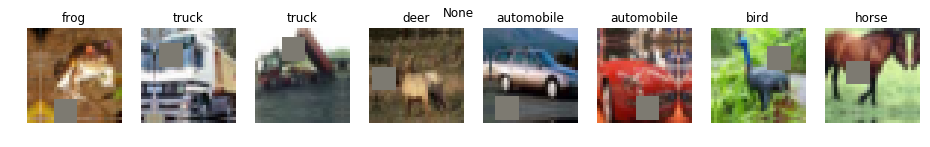

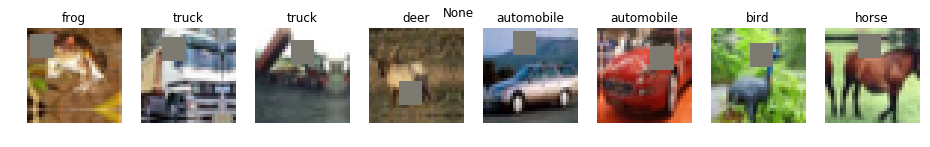

In [5]:
batches = train_batches(batch_size=8, transforms=(Crop(32, 32), FlipLR(), Cutout(8, 8)), shuffle=False)

layout([[partial(image_plot, img=x, title=cifar10_classes[y]) for x,y in zip(*next(iter(batches)).values())]], col_width=2, row_height=2)
layout([[partial(image_plot, img=x, title=cifar10_classes[y]) for x,y in zip(*next(iter(batches)).values())]], col_width=2, row_height=2);

Now let's see how fast it is:

In [7]:
t = Timer(synch=torch.cuda.synchronize)
batches = train_batches(batch_size=512, transforms=(Crop(32, 32), FlipLR(), Cutout(8, 8)))

for epoch in range(240):
    for batch in batches:
        pass
print(f'{t():.3f}s')

5.153s


This is great! We're able to iterate through 24 epochs of training data, applying data augmentation and shuffling in less than the time taken to transfer the dataset once to the CPU! Moreover, since we're no longer racing CPU preprocessing queues against the GPU, we can stop worrying about dataloading altogether, even if training gets faster. Note: we are relying on the fact that the dataset is small enough to store and manipulate as a whole in GPU memory, but a more sophisticated implementation could work around this - or one could switch to an industrial strength solution such as [Nvidia DALI](https://github.com/NVIDIA/DALI).

Let's see if this gives us a speedup on our baseline. The code we use here is essentially equivalent to the DAWNBench submission, apart from the GPU data processing.

In [9]:
baseline_net=network()
show(baseline_net)

pydot is needed for network visualisation

In [10]:
epochs, batch_size = 24, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, 5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

model = build_model(baseline_net, x_ent_loss)  
warmup_cudnn(model, next(iter(train_batches(batch_size, transforms))))
logs, state, timer = Table(), {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
for epoch in range(epochs):
    logs.append(union({'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))

/home/pdluser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:267: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/torch/csrc/utils/python_arg_parser.cpp:882.)


       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       5.1485       1.6349       0.4108       0.5503       1.4526       0.5022       5.1485
           2       5.1678       0.9433       0.6665       0.3004       0.9719       0.6840      10.3164
           3       5.1783       0.7265       0.7461       0.3009       0.7759       0.7298      15.4946
           4       5.1936       0.6410       0.7760       0.3019       1.5162       0.5607      20.6882
           5       5.2047       0.5606       0.8049       0.3021       1.1775       0.6162      25.8929
           6       5.2060       0.5124       0.8228       0.3027       0.5503       0.8108      31.0989
           7       5.2088       0.4473       0.8458       0.3029       0.4928       0.8297      36.3077
           8       5.2110       0.4221       0.8547       0.3026       0.6115       0.7967      41.5187
           9       5.2142       0.3852       0.8693       0.3029

Total training time (including the negligible time spent on preprocessing) is under 70s, moving us up two places to fourth on the leaderboard!

#### Aside: mixed precision training

In our original DAWNBench submission and in the code above, we simply converted the model to float16 without all the niceties of so-called [mixed precision training](https://arxiv.org/abs/1710.03740) although we include a basic sort of 'loss scaling' by summing rather than averaging losses in a batch. It is straightforward to implement proper mixed precision training but this adds about a second to overall training time and we found it to have no effect on final accuracy, so we continue to do without it below. For completeness, here is a simple implementation which might be useful elsewhere: 

In [11]:
FP32_PARAMS = 'fp32_params'

def copy_grads_to_master(batch, state):
    if not batch: return
    for float_param, param in zip(state[FP32_PARAMS], trainable_params(state[MODEL]).values()):
        if float_param.grad is None: 
            float_param.grad = float_param.data.new(*float_param.data.size())
        float_param.grad.data.copy_(param.grad.data)    
    
def update_params_from_master(batch, state):
    if not batch: return
    for float_param, param in zip(state[FP32_PARAMS], trainable_params(state[MODEL]).values()):
        param.data.copy_(float_param)
    
train_steps_mixed_precision = (forward(training_mode=True),  log_activations(('loss', 'acc')), backward(torch.float32), copy_grads_to_master, opt_steps, update_params_from_master)

In [12]:
epochs, batch_size =24, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, 5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

model = build_model(network(), x_ent_loss)
fp32_params = [v.clone().to(torch.float32) for v in trainable_params(model).values()]
logs, state, timer = Table(), {MODEL: model, OPTS: [SGD(fp32_params, opt_params)], FP32_PARAMS: fp32_params}, Timer(torch.cuda.synchronize)
for epoch in range(epochs):
    logs.append(union({'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), train_steps=train_steps_mixed_precision)))

/home/pdluser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  


       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       5.1978       1.6362       0.4110       0.2959       1.5309       0.4806       5.1978
           2       5.1746       0.9530       0.6580       0.2971       0.8653       0.7125      10.3724
           3       5.2047       0.7285       0.7463       0.2992       0.8478       0.7218      15.5771
           4       5.2185       0.6191       0.7845       0.3000       0.5850       0.8029      20.7955
           5       5.2370       0.5669       0.8039       0.3007       0.6038       0.7933      26.0325
           6       5.2412       0.4941       0.8302       0.3016       0.6205       0.7925      31.2737
           7       5.2598       0.4492       0.8448       0.3020       0.6233       0.7911      36.5335
           8       5.2659       0.4101       0.8588       0.3020       0.5517       0.8091      41.7994
           9       5.2686       0.3797       0.8715       0.3023

### Moving max-pool layers (64s)


Max-pooling commutes with a monotonic-increasing activation function such as ReLU. It should be more efficient to apply pooling first. This is the sort of thing a friendly compiler might do for you, but for now let's switch the order by hand:


In [13]:
conv_pool_block_opt = lambda c_in, c_out: reorder(conv_pool_block(c_in, c_out), ('conv', 'norm', 'pool', 'act'))
show(network(conv_pool_block=conv_pool_block_opt))

pydot is needed for network visualisation

In [14]:
epochs, batch_size = 24, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, 5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

model = build_model(network(conv_pool_block=conv_pool_block_opt), x_ent_loss)
logs, state, timer = Table(), {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
for epoch in range(epochs):
    logs.append(union({'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       5.0569       1.6416       0.4109       0.2889       1.2009       0.5575       5.0569
           2       5.0423       0.9398       0.6649       0.2895       1.0367       0.6596      10.0992
           3       5.0598       0.7274       0.7454       0.2903       0.6625       0.7770      15.1590
           4       5.0651       0.6230       0.7838       0.2913       0.7818       0.7328      20.2241
           5       5.0701       0.5519       0.8079       0.2912       0.6476       0.7792      25.2942
           6       5.0714       0.4902       0.8306       0.2916       0.6296       0.7888      30.3656
           7       5.0860       0.4452       0.8469       0.2921       0.5398       0.8160      35.4517
           8       5.0907       0.4091       0.8600       0.2922       0.5207       0.8191      40.5423
           9       5.0908       0.3844       0.8683       0.2922

A further 3s off! 

Perhaps we should try something more radical and move max-pooling before batch norm. This will achieve a further efficiency gain but will change the network 
so we need to test the effect on training.


In [19]:
conv_pool_block_pre = lambda c_in, c_out: reorder(conv_pool_block(c_in, c_out), ('conv', 'pool', 'norm', 'act'))

maxpool_pre_net = network(conv_pool_block=conv_pool_block_pre)
show(maxpool_pre_net)

pydot is needed for network visualisation

In [ ]:
epochs, batch_size = 24, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, 5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(maxpool_pre_net, x_ent_loss)
    state, timer = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))       
summary(logs)

The results show a small negative effect on test accuracy to 94.0% (mean of 50 runs) compared to our baseline of 94.1%. They also show a substantial 5s reduction in training time! We can restore the previous accuracy by adding an extra epoch to training. This is the only time in the post that we select an 'improvement' that leads to worse accuracy! The 5s gain from a more efficient network more than compensates the 2.5s loss from the extra training epoch. The net effect brings our time to 64s, up to third place on the leaderboard.

### Label smoothing (59s)

[Label smoothing](https://arxiv.org/abs/1512.00567) is a well-established trick for improving the training speed and generalization of neural nets in classification problems. It involves blending the one-hot target probabilities with a uniform distribution over class labels inside the cross entropy loss. This helps to stabilise the output distribution and prevents the network from making overconfident predictions which might inhibit further training. Let's give it a try - the label smoothing parameter of 0.2 has been very roughly hand-optimised but the result is not too sensitive to a range of choices.

In [15]:
show(label_smoothing_loss(alpha=0.2), size=2)

pydot is needed for network visualisation

In [20]:
epochs, batch_size = 25, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(maxpool_pre_net, label_smoothing_loss(0.2))
    state, timer = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

         run        epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time


KeyboardInterrupt: 

Test accuracy improves to 94.2% (mean of 50 runs.) We can trade this for training time by reducing the number of epochs. As a rule of thumb, we reduce training by one epoch for each 0.1% of test accuracy improvement, since this roughly tracks the gain from an extra epoch of training. We reduce the warmup period - during which learning rates increase linearly - in proportion to the overall number of epochs. 

Accuracy for 23 epochs of training is 94.1% and training time has dipped under a minute!

### CELU activations (52s)

We might hope to help the optimisation process by using a smooth activation function, rather than ReLU with its delta-function of curvature at the origin. This may also help generalisation since smoothed functions lead to a less expressive function class - in the large smoothing limit we recover a linear network. 

We are otherwise happy with ReLU so we're going to pick a simple smoothed-out alternative. Our choice is the Continuously Differentiable Exponential Linear Unit or [CELU](https://arxiv.org/abs/1704.07483) activation since it is smooth (unlike ELU) and the PyTorch implementation is faster than that of the otherwise perfectly adequate Softplus activation. In addition to smoothing, CELU applies an x- and y-shift to ReLU as shown below, but these are largely irrelevant given our use of batch norm.

In [22]:
alpha = 0.075

funcs = {
    'CELU(x; α)': nn.CELU(alpha),
    'ReLU(x+α)-α': lambda x: torch.nn.functional.relu(x+alpha) - alpha,
}

xs = torch.tensor(np.arange(-1, 1, 0.01))
data = pd.DataFrame([{'func': k, 'x': float(to_numpy(x)), 'y': float(to_numpy(f(x)))} for x in xs for k,f in funcs.items()])
# alt.Chart(data).mark_line().encode(x='x', y='y', color='func')

Let's see how it works  - as usual the smoothing parameter $\alpha$ has been roughly manually tuned.

In [23]:
celu_net = network(conv_pool_block=conv_pool_block_pre, types={nn.ReLU: partial(nn.CELU, alpha=0.075)})
show(celu_net)

pydot is needed for network visualisation

In [24]:
epochs, batch_size = 23, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(celu_net, label_smoothing_loss(0.2))
    state, timer = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

         run        epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time


This gives an impressive improvement to 94.3% test accuracy (mean of 50 runs) allowing a further 3 epoch reduction in training and a 20 epoch time of 52s for 94.1% accuracy.

### Ghost batch norm (46s)



Batch norm seems to work best with batch size of around 32. The reasons presumably have to do with noise in the batch statistics and specifically a balance between a beneficial regularising effect at intermediate batch sizes and an excess of noise at small batches.

Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. It isn't supported directly in PyTorch but we can roll our own easily enough.

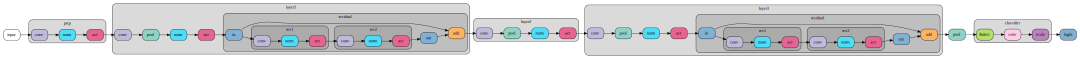

In [ ]:
ghost_bn_net = network(conv_pool_block=conv_pool_block_pre, types={
    nn.ReLU: partial(nn.CELU, 0.075), 
    BatchNorm: partial(GhostBatchNorm, num_splits=16)
})
show(ghost_bn_net)

In [ ]:
epochs, batch_size = 20, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

logs = Table(report=every(epochs, 'epoch'))
for run in range(N_RUNS):
    model = build_model(ghost_bn_net, label_smoothing_loss(0.2))
    state, timer = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

This gives a healthy boost to the 20 epoch test accuracy of 94.2%. As training becomes ever shorter, it is occasionally helpful to increase the learning rate to compensate. If we raise the max learning rate by 50% we can achieve 94.1% accuracy in 18 epochs and a training time of 46s.

In [ ]:
epochs, batch_size = 18, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

logs = Table(report=every(epochs, 'epoch'))
for run in range(N_RUNS):
    model = build_model(ghost_bn_net, label_smoothing_loss(0.2))
    state, timer = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

### Frozen batch norm scales (43s)

Batch norm standardises the mean and variance of each channel but is followed by a learnable scale and bias. Our batch norm layers are succeeded by ReLUs, so the learnable biases could allow the network to optimise the level of sparsity per channel. On the other hand, if channel scales vary substantially this might reduce the effective number of channels and introduce a bottleneck. Let's have a look at the dynamics of these parameters during training:

In [ ]:
epochs, batch_size = 18, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

model = build_model(ghost_bn_net, label_smoothing_loss(0.2))
state, timer, logs = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize), Table(report=every(epochs, 'epoch'))
for epoch in range(epochs):
    logs.append(union({'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), 
                                                      on_epoch_end=partial(log_weights, weights={k: v for k,v in trainable_params(model).items() if 'norm' in k}))))
data = pd.DataFrame([{'epoch': epoch, 'type': weight.split('.')[1], 'layer': weight.split('_norm')[0], 'channel': channel, 'value': value} 
                     for epoch, epoch_vals in enumerate(state[WEIGHT_LOG], 1) 
                     for weight, weight_vals in epoch_vals.items() 
                     for channel, value in enumerate(weight_vals[:8], 1)])

alt.Chart(data).mark_line(opacity=0.7).encode(x='epoch', y='value', color=alt.Color('layer', sort=['prep']), detail='channel', column='type').resolve_scale(y='independent')

There's a lot going on in these plots, but one thing that sticks out is that the scales are not doing much learning and evolve largely under the control of weight decay. Let's try freezing these at a constant value of $1/4$ - roughly their average at the midpoint of training. The learnable scale for the final layer is somewhat larger but we can adjust the scaling of the network output to compensate. 

Actually we can fix the batch norm scales to $1$ instead if we rescale the $\alpha$ parameter of CELU by a compensating factor of $4$ and the learning rate and weight decay for the batch norm biases by $4^2$ and $1/4^2$ respectively. We prefer to do things this way since it makes the impact of the channel scales on the learning rate dynamics of the biases more explicit.

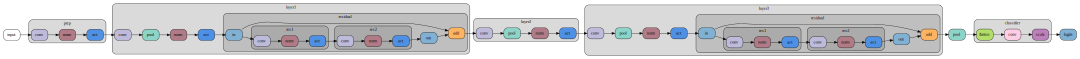

In [ ]:
frozen_bn_scale_net = network(conv_pool_block=conv_pool_block_pre, scale=1/16, types={
    nn.ReLU: partial(nn.CELU, 0.3),
    BatchNorm: partial(GhostBatchNorm, num_splits=16, weight=False)
})
show(frozen_bn_scale_net)

In [ ]:
epochs, batch_size = 18, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6*16, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size/16), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(frozen_bn_scale_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

Test accuracy improves to 94.2%. Interestingly, had we not increased the learning rate of the batch norm biases, we would have achieved a substantially lower accuracy as the reader can verify. This suggests that the learnable biases are indeed doing something useful - either learning appropriate levels of sparsity or perhaps just adding regularisation noise. Indeed we can improve things slightly by increasing the learning rate of the biases even further:



In [ ]:
epochs, batch_size = 18, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6*64, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(frozen_bn_scale_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

Finally we can use the increased accuracy to reduce training to 17 epochs. The new test accuracy is 94.1% and most importantly we've overtaken the 8 GPUs of BaiduNet9P with a time of 43s, placing us second on the leaderboard!

### Input patch whitening (36s)

Batch norm does a good job at controlling distributions of individual channels but doesn't tackle covariance between channels and pixels. Controlling the covariance at internal layers, using a 'whitening' version of batch norm, might be helpful but would entail extra computation as well as non-trivial implementation effort. We are going to focus on the easier problem at the input layer.

The classic way to remove input correlations is to perform global PCA (or ZCA) whitening. We propose a patch-based approach which is agnostic to the total image size and more in keeping with the structure of a conv net. We are going to apply PCA whitening to 3×3 patches of inputs as an initial 3×3 convolution with fixed (non-learnable) weights. We will follow this with a learnable 1×1 convolution. The 27 input channels to this layer are a transformed version of the original 3×3×3 input patches whose covariance matrix is approximately the identity, which should make optimisation easier.

First let's plot the leading eigenvectors of the covariance matrix of 3×3 patches of the input data. The numbers in brackets are the square root of the corresponding eigenvalues to show the relative scales of variation along these directions and we plot the eigenvector with both signs to illustrate the direction of variation. As we might expect, variations in local brightness dominate.


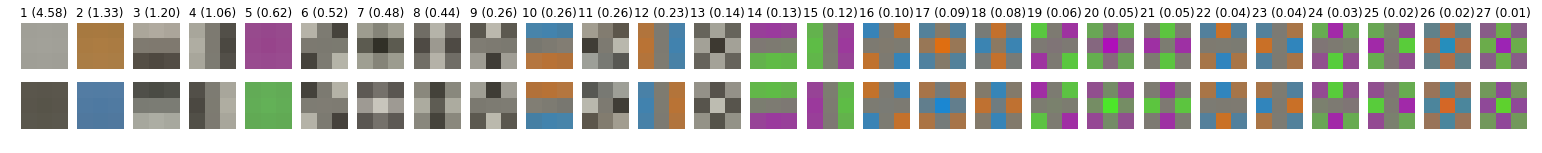

In [ ]:
def cov(X):
    X = X/np.sqrt(X.size(0) - 1)
    return X.t() @ X

def patches(data, patch_size=(3, 3), dtype=torch.float32):
    h, w = patch_size
    c = data.size(1)
    return data.unfold(2,h,1).unfold(3,w,1).transpose(1,3).reshape(-1, c, h, w).to(dtype)

def eigens(patches):
    n,c,h,w = patches.shape
    Σ = cov(patches.reshape(n, c*h*w))
    Λ, V = torch.symeig(Σ, eigenvectors=True)
    return Λ.flip(0), V.t().reshape(c*h*w, c, h, w).flip(0)

Λ, V = eigens(patches(train_set['data'][:10000,:,4:-4,4:-4])) #center crop to remove padding

layout([
    [partial(image_plot, img=V[i].to(torch.float16)*3, title=f'{i+1} ({torch.sqrt(Λ[i]):.2f})') for i in range(len(V))],
    [partial(image_plot, img=-V[i].to(torch.float16)*3, title='') for i in range(len(V))],
], col_width=1.0, row_height=1.0
);

Now let's replace the first 3×3 convolution of the network with a fixed 3×3 whitening convolution to equalise the scales of the eigenpatches above, followed by a learnable 1×1 convolution. 

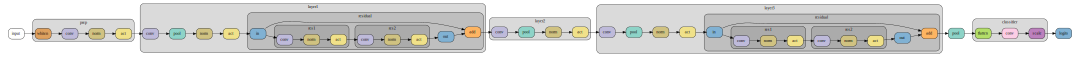

In [ ]:
def whitening_block(c_in, c_out, Λ=None, V=None, eps=1e-2):
    filt = nn.Conv2d(3, 27, kernel_size=(3,3), padding=(1,1), bias=False)
    filt.weight.data = (V/torch.sqrt(Λ+eps)[:,None,None,None])
    filt.weight.requires_grad = False 
                                   
    return {
        'whiten': (identity, {'value': filt}),
        'conv': conv(27, c_out, kernel_size=(1, 1), bias=False),
        'norm': batch_norm(c_out), 
        'act':  relu(),
    }

input_whitening_net = network(conv_pool_block=conv_pool_block_pre, prep_block=partial(whitening_block, Λ=Λ, V=V), scale=1/16, types={
    nn.ReLU: partial(nn.CELU, 0.3),
    BatchNorm: partial(GhostBatchNorm, num_splits=16, weight=False)
})
show(input_whitening_net)

In [ ]:
epochs, batch_size = 17, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(8, 8))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 0.6*64, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(input_whitening_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

17 epoch test accuracy jumps to 94.4% allowing a further 2 epoch reduction in training time. 15 epochs brings a test accuracy of 94.1% in 39s, closing in on the 4-GPU, test-time-augmentation assisted DAWNBench leader! If we increase the maximum learning rate by a further ~50% and reduce the amount of cutout augmentation, from 8×8 to 5×5 patches, to compensate for the extra regularisation that the higher learning rate brings, we can remove a further epoch and reach 94.1% test accuracy in 36s, moving us narrowly into top spot on the leaderboard!!

In [ ]:
epochs, batch_size = 14, 512
transforms = (Crop(32, 32), FlipLR(), Cutout(5, 5))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 1.0, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs], [0.0, 1.0*64, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(input_whitening_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size))))
summary(logs)

### Exponential moving averages (33.5s)



High learning rates are necessary for rapid training since they allow stochastic gradient descent to traverse the necessary distances in parameter space in a limited amount of time. On the other hand, learning rates need to be annealed towards the end of training to enable optimisation along the steeper and noisier directions in parameter space. Parameter averaging methods allow training to continue at a higher rate whilst potentially approaching minima along noisy or oscillatory directions by averaging over multiple iterates. 

We shall investigate exponential moving averaging of parameters which is a standard approach. For efficiency reasons we update the moving average every 5 batches since we find that more frequent updates don't improve things. We need to choose a new learning rate schedule with higher learning rates towards the end of training, and a momentum for the moving average. For the learning rate, a simple choice is to stick with the piecewise linear schedule that we've been using throughout, floored at a low fixed value for the last 2 epochs and we choose a momentum of 0.99 so that averaging takes place over a timescale of roughly the last epoch.

Test accuracy improves to 94.3% allowing us to trim a further epoch. 13 epoch training reaches a test accuracy of 94.1%, achieving a training time below 34s and a 10× improvement over the single-GPU state-of-the-art at the outset of the series!


In [ ]:
#Final training setup
epochs, batch_size, ema_epochs=13, 512, 2
transforms = (Crop(32, 32), FlipLR(), Cutout(5, 5))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 1.0, 0.1], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 1.0*64, 0.1*64], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(input_whitening_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, VALID_MODEL: copy.deepcopy(model), OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), train_steps=(*train_steps, update_ema(momentum=0.99, update_freq=5)))))
summary(logs)

### Test-time augmentation (26s)

Suppose that you'd like your network to classify images the same way under horizontal flips of the input. One possibility, that we've been using till now, is to present the network with a large amount of data, possibly augmented by label preserving left-right flips, and hope that the network will eventually learn the invariance through extensive training. 

A second approach, which doesn't leave things to chance, is to present both the input image and its horizontally flipped version and come to a consensus by averaging network outputs for the two versions, thus guaranteeing invariance. This eminently sensible approach goes by the name of test-time augmentation.

At training time, we still present the network with a single version of each image - potentially subject to random flipping as a data augmentation so that different versions are presented on different training epochs. An alternative, would be to use the same procedure at training time as at test time and present each image along with its mirror. In this case, we could claim to have changed the network by splitting into two identical branches, one of which sees the flipped image, and then merging at the end. Through this lens, the original training can be viewed as a stochastic training procedure for a weight-tied, two branch network in which a single branch is 'dropped-out' for each training example.

This dropout-training viewpoint makes it clear that any attempt to introduce a rule disallowing TTA from a benchmark is going to be fraught with difficulties. From this point of view, we have just introduced a larger network for which we have an efficient stochastic training methodology. On the other hand, if we don't limit the amount of work that we are prepared to do at test time then there are some obvious degenerate solutions in which training takes as little time as is required to store the dataset!

These arguments are not only relevant to artificial benchmarks but also to end use-cases. In some applications, classification accuracy is all that is desired and in that case TTA should most definitely be used. In other cases, inference time is also a constraint and a sensible approach is to maximise accuracy subject to such constraints. This is probably a good approach for training benchmarks too. 

In the case at hand, the Kakao Brain team has applied the simple form of TTA described here - presenting an image and its left-right mirror at inference time, thus doubling the computational load. More extensive forms of TTA are of course possible for other symmetries (such as translational symmetry, variations in brightness/colour etc.) but these would come at a higher computational cost. 

Now because these entries are based of a computationally light 9-layer ResNet _total inference time including TTA_ is likely to be much lower for these entries than for some of the 100+ layer networks that have been entered at earlier stages of the competition! According to our discussion above, any reasonable rule to limit this kind of approach should be based on inference time constraints and not an arbitrary feature of the implementation and so from this point-of-view, we should accept the approach.






Let's see what improvement TTA brings. We shall restrict ourselves to horizontal flip TTA for consistency with the current DAWNBench submissions and because this seems a sweet spot between accuracy and inference cost. With our current network and 13 epoch training setup, the test accuracy with TTA rises to 94.6%, making this the largest individual effect we've studied today. 



In [ ]:
valid_steps_tta = (forward_tta([identity, flip_lr]), log_activations(('loss', 'acc')))

In [ ]:
epochs, batch_size, ema_epochs=13, 512, 2
transforms = (Crop(32, 32), FlipLR(), Cutout(5, 5))
opt_params = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 1.0, 0.1], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 1.0*64, 0.1*64], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(input_whitening_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, VALID_MODEL: copy.deepcopy(model), OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), 
                                                                        train_steps=(*train_steps, update_ema(momentum=0.99, update_freq=5)),
                                                                        valid_steps=valid_steps_tta)))
summary(logs)

If we remove the remaining cutout data augmentation - which is getting in the way on such a short training schedule - we can reduce training to 10 epochs (!) and achieve a TTA test accuracy of 94.1% in 26s!

In [ ]:
epochs, batch_size, ema_epochs=10, 512, 2
transforms = (Crop(32, 32), FlipLR())
opt_params = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 1.0, 0.1], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 1.0*64, 0.1*64], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

logs = Table(report=every(epochs,'epoch'))
for run in range(N_RUNS):
    model = build_model(input_whitening_net, label_smoothing_loss(0.2))
    is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
    state, timer = {MODEL: model, VALID_MODEL: copy.deepcopy(model), OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
    for epoch in range(epochs):
        logs.append(union({'run': run+1, 'epoch': epoch+1}, train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), 
                                                                        train_steps=(*train_steps, update_ema(momentum=0.99, update_freq=5)),
                                                                        valid_steps=valid_steps_tta)))
summary(logs)

### Training to convergence

Here is a simple experiment to investigate whether the gains in training speed that we have collected also translate into gains in final accuracy for the model if it is trained to convergence. We have every reason to believe that this should be the case, if only because many of the techniques that we have been using today were originally proposed as techniques to improve converged accuracy on ImageNet! If it is the case that the same techniques which speed up training time to 94% accuracy on CIFAR10 also improve converged accuracy on ImageNet, then this suggests a rather effective way to accelerate research on the latter problem!

Unlike the previous experiments, this is going to be very rough and ready and we leave it to future work to do this experiment more carefully. We are going to pick a fixed learning rate schedule with lower learning rates appropriate for longer training and increase the amount of cutout augmentation to 12×12 patches to allow training for longer without overfitting. We will fix the other hyperparameters as they were above and train both the baseline network and the final network for a range of different times from 24 to 100 epochs. Finally we're going to break all the rules and only run each experiment 5 times! Here are the results: 

#### Convergence experiment

In [ ]:
valid_steps_tta = (forward_tta([identity, flip_lr]), log_activations(('loss', 'acc')))

def train_epoch_tta(state, timer, train_batches, valid_batches, train_steps=train_steps, 
                    valid_steps=valid_steps, valid_steps_tta=valid_steps_tta, on_epoch_end=identity):
    train_summary, train_time = epoch_stats(on_epoch_end(reduce(train_batches, state, train_steps))), timer()
    valid_summary, valid_time = epoch_stats(reduce(valid_batches, state, valid_steps)), timer(update_total=False) #DAWNBench rules
    valid_summary_tta, valid_time_tta = epoch_stats(reduce(valid_batches, state, valid_steps_tta)), timer(update_total=False) #DAWNBench rules
    return {
        'train': union({'time': train_time}, train_summary), 
        'valid': union({'time': valid_time}, valid_summary), 
        'tta': union({'time': valid_time}, valid_summary_tta), 
        'total time': timer.total_time
    }

#baseline model
transforms = (Crop(32, 32), FlipLR(), Cutout(12, 12))
logs = Table()
for run in range(5):
    for epochs in [24, 40, 60, 80, 100]:
        opt_params = {'lr': lr_schedule([0, 5, epochs], [0.0, 0.4, 0.0], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}

        model = build_model(network(), x_ent_loss)
        state, timer = {MODEL: model, OPTS: [SGD(trainable_params(model).values(), opt_params)]}, Timer(torch.cuda.synchronize)
        for epoch in range(epochs-1):
            train_epoch(state, timer, train_batches(batch_size, transforms),  valid_batches(batch_size)) 
        logs.append(union({'run': run+1, 'epoch': epochs, 'experiment': baseline}, 
                          train_epoch_tta(state, timer, train_batches(batch_size, transforms),  valid_batches(batch_size), 
                                          valid_steps_tta=valid_steps_tta)))   
#final model
ema_epochs=2
for run in range(5):
    for epochs in [24, 40, 60, 80, 100]:
        opt_params = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 0.4, 0.04], batch_size), 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)}
        opt_params_bias = {'lr': lr_schedule([0, epochs/5, epochs - ema_epochs], [0.0, 0.4*64, 0.04
                                                                          *64], batch_size), 'weight_decay': Const(5e-4*batch_size/64), 'momentum': Const(0.9)}

        model = build_model(input_whitening_net, label_smoothing_loss(0.2))
        is_bias = group_by_key(('bias' in k, v) for k, v in trainable_params(model).items())
        state, timer = {MODEL: model, VALID_MODEL: copy.deepcopy(model), OPTS: [SGD(is_bias[False], opt_params), SGD(is_bias[True], opt_params_bias)]}, Timer(torch.cuda.synchronize)
        for epoch in range(epochs-1):
            train_epoch(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), 
                                                                            train_steps=(*train_steps, update_ema(momentum=0.99, update_freq=5)))
        logs.append(union({'run': run+1, 'epoch': epochs, 'experiment': final}, 
                          train_epoch_tta(state, timer, train_batches(batch_size, transforms), valid_batches(batch_size), 
                                          train_steps=(*train_steps, update_ema(momentum=0.99, update_freq=5)))))  
        
data = logs.df()

#### Results

In [ ]:
scale = alt.Scale(zero=False)
c = alt.Chart(data).encode(x=alt.X('epoch', scale=scale), color='experiment')

c1=(c.mark_point().encode(y=alt.Y('valid_acc',scale=scale, axis=alt.Axis(title='valid acc'))) + 
c.mark_line().encode(y=alt.Y('mean(valid_acc)',scale=scale)))

c2=(c.mark_point().encode(y=alt.Y('tta_acc',scale=scale, axis=alt.Axis(title='valid acc (tta)'))) + 
c.mark_line().encode(y=alt.Y('mean(tta_acc)',scale=scale)))

c1 | c2

alt.HConcatChart(...)

Despite the lack of tuning of the various extra hyperparameters of the final training setup for longer runs, it appears to maintain a healthy lead over the baseline even out to 100 epochs of training and approximate convergence. The final TTA accuracy of our little 9-layer ResNet at 80 epochs is 96.1% even though we never optimised anything for training above 94% accuracy! We could presumably go quite a bit higher with proper hyperparameter optimisation. 

It appears that 96% accuracy is reached in about 70 epochs and 3 minutes of total training time, answering a question that I've been asked several times by people who (perhaps rightly) believe that the 94% threshold of DAWNBench is too low. Note that we have made almost no attempt to optimise the 96% time and we would expect it to come down considerably from here.

### Final thoughts

Thanks to everyone who contributed to, supported or provided feedback on the project. Special thanks to Sam Davis, to Thomas Read for his work last summer on what became the post on weight decay and to everyone at Myrtle.

It has been tremendous fun working on this project, exploring dynamics of neural network training and extending the work of others to bring training times to a level where rapid experimentation becomes possible. I hope that the reader will find this useful in their work and believe that training times have a long way to fall yet (or accuracies improve if that's your thing!) through further algorithmic developments.

At the outset of the series I half joked that if we could achieve 100% compute efficiency, training should take 40s. I would have been surprised to find that target surpassed by the end of the series with compute efficiency little better than it ever was! There is much scope for improvement on that front as well.